### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
) 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(batchSize, filePath, split):
    """
    Prepare and load data with ratio of train:val:test ratio of 60:20:20 if split
    enabled.

    Inputs
    -------
    batchSize: (int) number of samples per batch
    filePath: (string) Directory containing class folders
    split: (bool) to split data into training, testing, and valid sets

    Outputs
    -------
    train: (iterable) training dataset organized according to batch size
    val: (iterable) validation dataset organized according to batch size
    test: (iterable) testing dataset organized according to batch size
    """

    # Process images by transforming to tensors and normalize to range [-1,1]
    transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.ToTensor()])
    
    # Import data 
    data = torchvision.datasets.ImageFolder(filePath, transform=transform)

    torch.manual_seed(69)

    # split data into train, test, and valid sets
    if (split):
        trainLen = int( round(0.6 * len(data)) )
        testLen = int( round(0.2 * len(data)) )
        valLen = int( round(0.2 * len(data)) )

        train, test, valid = torch.utils.data.random_split(data, 
                                                       [trainLen,testLen,valLen])
        # Load train, test, and valid data
        trainLoader = torch.utils.data.DataLoader(train, batch_size=batchSize,
                                                shuffle=True)
        testLoader = torch.utils.data.DataLoader(test, batch_size=batchSize,
                                                shuffle=True)
        valLoader = torch.utils.data.DataLoader(valid, batch_size=batchSize,
                                                shuffle=True)
        
        return trainLoader, testLoader, valLoader
    
    else:
        return torch.utils.data.DataLoader(data, batch_size=batchSize,
                                                shuffle=True)


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?



---


*   2 convolution layers (with kernel size 5)
*   3 input channels (RGB), with 5 output channels in the first convolution layer and 10 in the second convolution layer




*   2 pooling layers (with kernel size 2, stride 2) to consolodate information after each convolution layer


*   2 fully connected layers after the second pooling layer 
*   ReLu used as activation function
*   442982 hidden parameters






In [ ]:
class CNN( nn.Module ):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(250, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool( F.sigmoid(self.conv1(x)) )
        x = self.pool( F.sigmoid(self.conv2(x)) )
        # print(x.shape)
        x = x.view(-1, 250) # flatten tensor
        x = F.sigmoid( self.fc1(x) )
        return self.fc2(x)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class fc( nn.Module ):
    def __init__(self):
        super(fc, self).__init__()
        self.fc1 = nn.Linear(250, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.fc1(x)
        return self.fc2(x)

In [ ]:
model = CNN()
print(count_parameters(model))

mod = fc()
print(count_parameters(mod))

print(count_parameters(model)-count_parameters(mod))

8926
8362
564


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
def train_net(train,valid, net, batchSize, lr, mtm, epochs, lossType):
    """
    Inputs
    ------
    train, valid: datasets
    net: (nn.Module) NN model
    batchSize: (int) number of samples per batch
    lr: (int) learning rate
    mtm: (int) momentum
    epochs: (int) number of iterations over whole batch of data
    lossType: (string) 'BCE' or 'CE'
    """

    # define loss function and optimizer specified by lossType
    criterion = nn.BCEWithLogitsLoss() if lossType == 'BCE' else nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mtm)

    # Set up accounting for training and validation sets 
    trainReport = [ [], [] ]    # loss [0] & acc [1]
    validReport = []            # acc only

    # Now let's start training
    for epoch in range(epochs):
        
        print(f"[Epoch: {epoch}]")

        for images, labels in iter(train):

            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            out = net(images)               # forward pass
            loss = criterion(out, labels)   # get loss
            loss.backward()                 # compute updates for params
            optimizer.step()                # update params
            optimizer.zero_grad()

            # Report average loss in iteration
            trainReport[0].append( float(loss)/batchSize )

            # Report accuracy in iteration
            trainReport[1].append( get_accuracy(net, train) )
            validReport.append( get_accuracy(net, valid) )

            print(f"ACC: {trainReport[1][-1]} | LOSS: {trainReport[0][-1]}")
    
    # Aight, we're done here
    plot( trainReport, validReport, np.arange(1, len(trainReport[0]) + 1).tolist() ) 

In [ ]:
def get_accuracy(net, loader):
    """
    Inputs
    ------
    net: (nn.Module) NN model
    loader: (dataLoader) input data

    Output
    ------
    (int) accuracy of NN model on input data
    """
    correct = 0
    total = 0

    for images, labels in iter(loader):

        if torch.cuda.is_available():
            images = images.cuda()
            lables = labels.cuda()

        out = net(images)

        # index with maximum score is prediction
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += images.shape[0]

    return correct / total

def plot(trainReport, validReport, xAxis):
    """
    Use matlibplot to make accuracy and loss plots for training and test sets.
    Print out final loss and accuracies.

    Inputs:
    ------
    trainReport: (array of arrays) array[0]=loss data, array[1]=acc data
    validReport: (array) valid acc
    xAxis: (array) array populated with number of iterations (1..n)
    """
    # Loss
    plt.title("Loss")
    plt.plot(xAxis, trainReport[0], label="Training")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Acc
    plt.title("Accuracy")
    plt.plot(xAxis, trainReport[1], label="Training")
    plt.plot(xAxis, validReport, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")
    plt.show()

    print("-----------------FINAL LOSS-----------------")
    print(f"Training        :   {trainReport[0][-1]}")

    print("-----------------FINAL  ACC-----------------")
    print(f"Training        :   {trainReport[1][-1]}")
    print(f"Validation      :   {validReport[-1]}")

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

**note:** validation and testing set are the same data

In [ ]:
net = CNN()
smallFilePath = '/content/drive/My Drive/APS360/smallGestureData'
split = False
batchSize = 7
lr = 0.01
mtm = 0.9
epochs = 50
lossType = 'CE'

train = load_data(batchSize, smallFilePath, split)
train_net(train, train, net, batchSize, lr, mtm, epochs, lossType)

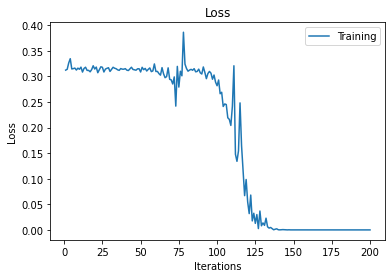

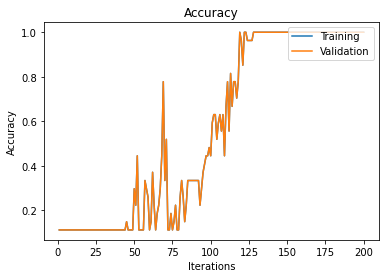





*   Final Training Loss: 6.226981245812827e-06
*   Final Training Acc: 1.0
*   Final Validation Acc: 1.0



### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.



1.   Learning rate
2.   Momentum
3.   Filter size





### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

Testing learning rates

In [ ]:
filePath = '/content/drive/My Drive/APS360/GestureData'
batchSize = 128
train, test, valid = load_data(batchSize, filePath, True)

In [ ]:
lr = 0.005
mtm = 0.9
epochs = 15
lossType = 'CE'

print(f"====================  LR={lr}  ====================")
train_net(train, valid, CNN(), batchSize, lr, mtm, epochs, lossType)

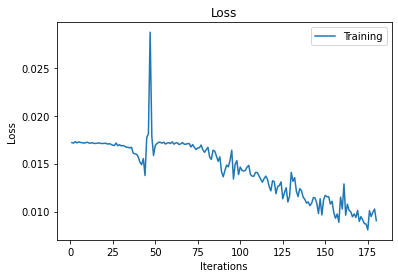

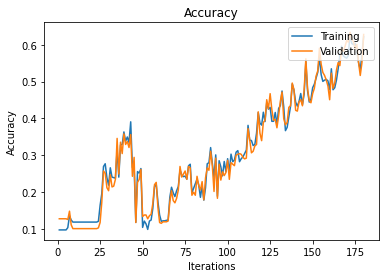

*   Final Training Loss: 0.009061561897397041
*   Final Training Acc: 0.6216586703221384
*   Final Validation Acc: 0.6275720164609053

In [ ]:
lr = 0.007
mtm = 0.9
epochs = 15
lossType = 'CE'

print(f"====================  LR={lr}  ====================")
train_net(train, valid, CNN(), batchSize, lr, mtm, epochs, lossType)

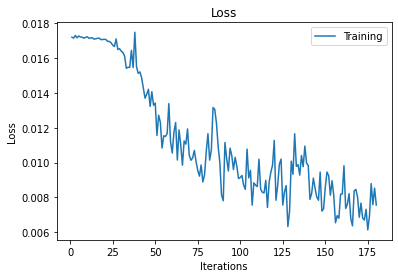


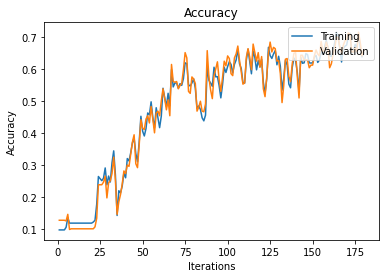

*   Final Training Loss: 0.00757125299423933
*   Final Training Acc: 0.6518163125428376
*   Final Validation Acc: 0.6584362139917695

Testing momentum

In [ ]:
lr = 0.007           # best one we have so far
mtm = 0.9
epochs = 15
lossType = 'CE'

train_net(train, valid, CNN(), batchSize, lr, mtm, epochs, lossType)

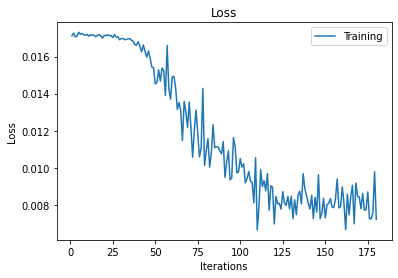

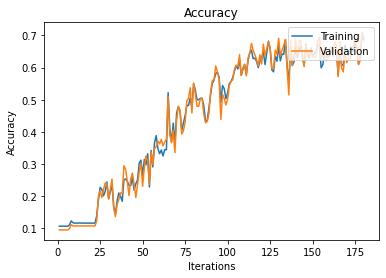

*   Final Training Loss: 0.0072183446027338505
*   Final Training Acc: 0.686771761480466
*   Final Validation Acc: 0.6954732510288066

In [ ]:
lr = 0.007           # best one we have so far
mtm = 0.8
epochs = 15
lossType = 'CE'

train_net(train, valid, CNN(), batchSize, lr, mtm, epochs, lossType)

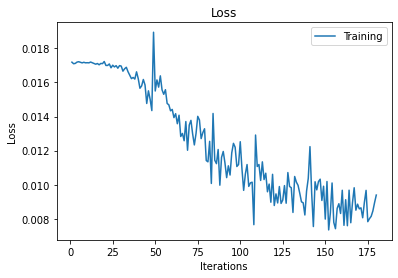

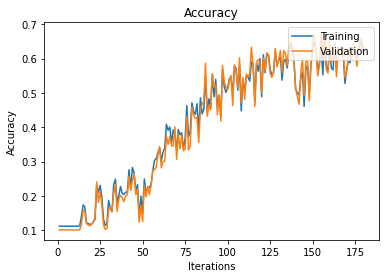


*   Final Training Loss: 0.009392835199832916
*   Final Training Acc: 0.6120630568882797
*   Final Validation Acc: 0.6172839506172839


Testing filter sizes

In [ ]:
class CNN( nn.Module ):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=10)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(10 * 49 * 49, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool( F.relu(self.conv1(img)) )
        x = self.pool( F.relu(self.conv2(x)) )
        # print(x.shape)
        x = x.view(-1, 10 * 49 * 49) # flatten tensor
        x = F.relu( self.fc1(x) )
        return self.fc2(x)

In [ ]:
lr = 0.007           # best one we have so far
mtm = 0.9           # best one we have so far
epochs = 15         
lossType = 'CE'

train_net(train, valid, CNN(), batchSize, lr, mtm, epochs, lossType)

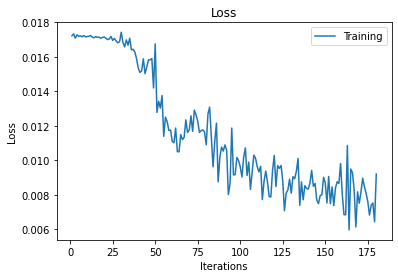

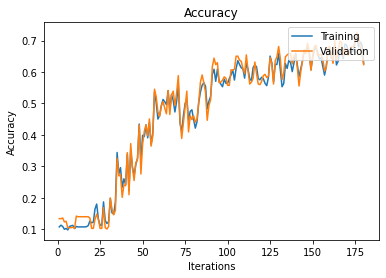

*   Final Training Loss: 0.009199773892760277
*   Final Training Acc: 0.6264564770390678
*   Final Validation Acc: 0.6234567901234568

In [ ]:
class CNN( nn.Module ):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size=8)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(10 * 50 * 50, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool( F.relu(self.conv1(img)) )
        x = self.pool( F.relu(self.conv2(x)) )
        # print(x.shape)
        x = x.view(-1, 10 * 50 * 50) # flatten tensor
        x = F.relu( self.fc1(x) )
        return self.fc2(x)

In [ ]:
lr = 0.007           # best one we have so far
mtm = 0.9           # best one we have so far
epochs = 15         
lossType = 'CE'

train_net(train, valid, CNN(), batchSize, lr, mtm, epochs, lossType)

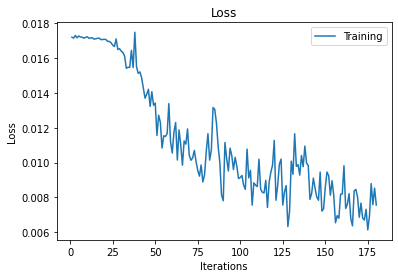

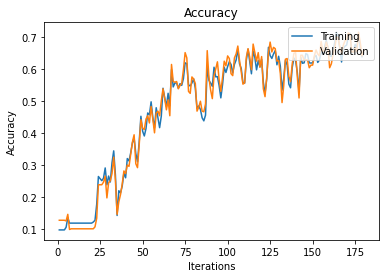

*   Final Training Loss: 0.00757125299423933
*   Final Training Acc: 0.6518163125428376
*   Final Validation Acc: 0.6584362139917695

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

Chose these because they produced the best validation accuracy:

1.   Learning rate - 0.007
2.   Momentum - 0.9
3.   Filter size - 5





### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
# Filter size 5
lr = 0.007           # best one we have so far
mtm = 0.9            # best one we have so far
epochs = 25         
lossType = 'CE'
net = CNN()

train_net(train, valid, net, batchSize, lr, mtm, epochs, lossType)

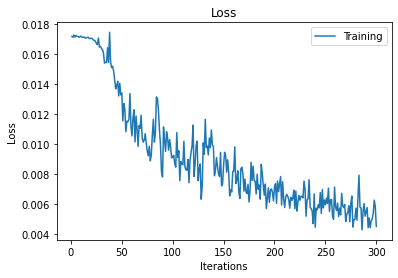

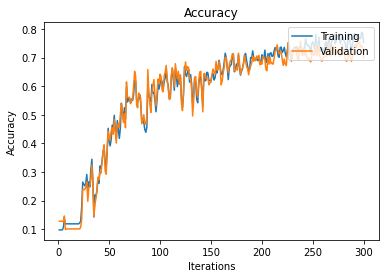

*   Final Training Loss: 0.004513178486377001
*   Final Training Acc: 0.752570253598355
*   Final Validation Acc: 0.6995884773662552

In [ ]:
print(f"Testing accuracy: {get_accuracy(net, test)}")

Testing accuracy: 0.6481481481481481


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
def get_features(data):
    f = []
    l = []
    for images, labels in iter(data):
        f.append( alexnet.features(images) )
        l.append( labels )
    return f, l

In [ ]:
trainFeatures, trainLabels = get_features(train)
validFeatures, validLabels = get_features(valid)
testFeatures, testLabels = get_features(test)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
class AlexNet( nn.Module ):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(256, 512, kernel_size=1)
        self.conv2 = nn.Conv2d(512, 1048, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(51 * 1048, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, img):
        x = self.pool( F.relu(self.conv1(img)) )
        x = self.pool( F.relu(self.conv2(x)) )
        print(x.shape)
        x = x.view(-1, 51 * 1048) # flatten tensor
        x = F.relu( self.fc1(x) )
        return self.fc2(x)

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
def train_alexnet(train, trainLabels,valid, validLables, net, batchSize, lr, mtm, epochs, lossType):
    """
    Inputs
    ------
    train, valid: alexnet features
    net: (nn.Module) NN model
    batchSize: (int) number of samples per batch
    lr: (int) learning rate
    mtm: (int) momentum
    epochs: (int) number of iterations over whole batch of data
    lossType: (string) 'BCE' or 'CE'
    """

    # define loss function and optimizer specified by lossType
    criterion = nn.BCEWithLogitsLoss() if lossType == 'BCE' else nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=mtm)

    # Set up accounting for training and validation sets 
    trainReport = [ [], [] ]    # loss [0] & acc [1]
    validReport = []            # acc only

    # Now let's start training
    for epoch in range(epochs):
        
        print(f"[Epoch: {epoch}]")

        for features, labels in zip(train, trainLabels):

            out = net(torch.from_numpy(features.detach().numpy()))               # forward pass
            loss = criterion(out, labels)   # get loss
            loss.backward()                 # compute updates for params
            optimizer.step()                # update params
            optimizer.zero_grad()

            # Report average loss in iteration
            trainReport[0].append( float(loss)/batchSize )

            # Report accuracy in iteration
            trainReport[1].append( get_accuracy(net, train) )
            validReport.append( get_accuracy(net, valid) )

            print(f"ACC: {trainReport[1][-1]} | LOSS: {trainReport[0][-1]}")
    
    # Aight, we're done here
    plot( trainReport, validReport, np.arange(1, len(trainReport[0]) + 1).tolist() ) 

In [ ]:
def get_accuracy(net, loader):
    """
    Inputs
    ------
    net: (nn.Module) NN model
    loader: (dataLoader) input data

    Output
    ------
    (int) accuracy of NN model on input data
    """
    correct = 0
    total = 0

    for images, labels in zip(data, labels):
        
        out = net(images)

        # index with maximum score is prediction
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += images.shape[0]

    return correct / total

In [ ]:
AlexNet = AlexNet()
batchSize = 128
lr = 0.007
mtm = 0.9
epochs = 1
train_alexnet(trainFeatures, trainLabels, validFeatures, validLabels, AlexNet, batchSize, lr, mtm, epochs, 'CE')

In [ ]:
print(trainFeatures.shape)

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())